In [1]:
import lightning as L
import torch

from data.datamodule import BlenderDataModule
from model.lightningmodule import MobileR2LLighningModule

In [2]:
data_path = "../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego"
datamodule = BlenderDataModule(data_path, 4, 16, rand=True)
model = MobileR2LLighningModule(5e-4, 16*3, 10, 256, 16, 3)
trainer = L.Trainer(
    enable_checkpointing=False,
    max_steps=10_000
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/joze/envs/sandbox-venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [31]:
near = 1
far = 3
num_samples = 3
H, W, = 1, 1
rand = True

depths = torch.linspace(near, far, num_samples).view(num_samples, 1, 1, 1)
print(depths)
if rand:
    noise = torch.rand([num_samples, 1, H, W]) - 0.5
    noise *= (far - near) / num_samples
    depths = torch.clamp(depths + noise, near, far)

depths

tensor([[[[1.]]],


        [[[2.]]],


        [[[3.]]]])


tensor([[[[1.0000]]],


        [[[2.1096]]],


        [[[2.8550]]]])

In [3]:
trainer.fit(
    model,
    datamodule,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | MobileR2L             | 3.2 M 
1 | train_psnr | _PeakSignalNoiseRatio | 0     
2 | val_psnr   | _PeakSignalNoiseRatio | 0     
3 | test_psnr  | _PeakSignalNoiseRatio | 0     
-----------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.629    Total estimated model params size (MB)


Epoch 1:  37%|███▋      | 739/2000 [08:20<14:13,  1.48it/s, v_num=10, train_loss=0.0465, train_psnr=13.30, val_psnr=9.910] 

/home/joze/envs/sandbox-venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [19]:
MobileR2LLighningModule.load_from_checkpoint("../../checkpoints/epoch=96-step=64100.ckpt")

MobileR2LLighningModule(
  (model): MobileR2L(
    (emb): Embedder()
    (head): Sequential(
      (0): Conv2d(1008, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
    (body): Sequential(
      (0): ResNetBlock(
        (conv1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): ResNetBlock(
        (conv1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (2): ResNetBlock(
   

searching for images...
loading poses...
done
[PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00000.npy'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00001.npy'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00002.npy')] [PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/0.png'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/1.png'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/2.png')]
tensor(6.1634)


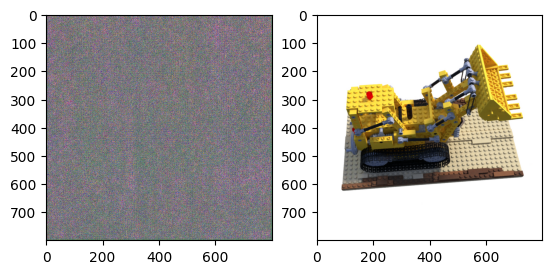

In [3]:
from matplotlib import pyplot as plt
import torch

datamodule.setup("fit")
rays, img = datamodule.train[0]

with torch.no_grad():
    pred_img = model.model(rays.unsqueeze(0))

print(model.train_psnr(pred_img, img))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(pred_img.squeeze(0).permute(1, 2, 0))
ax[1].imshow(img.permute(1, 2, 0))